## initialize


In [18]:
import sys
import os
import requests
import tensorboard
from torchvision import transforms

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
 

from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block
from timm.models.layers import to_2tuple

from util.pos_embed import get_2d_sincos_pos_embed

#from models_mae import MaskedAutoencoderViT
from leo_model_mae import MaskedAutoencoderViT

from itertools import chain

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# MAE Pretrain

## mae_pass function

In [37]:
def mae_pass(x, model, mask_ratio, alt=False, norm_pix_loss=False):
    # load reconstructed y and masks
    x.to('cpu')
    model.to('cpu')
    
    loss, y, mask = model(x.float(), mask_ratio=mask_ratio) 
    #print("y shape:", y.shape, ", mask (1-remove or 0-keep) shape:", mask.shape)

    y = model.unpatchify(y)
    #y = torch.einsum('nchw->nhwc', y).detach().cpu()
    y = y.detach().squeeze()
    #mask = model.unpatchify(mask.unsqueeze(0)).numpy().squeeze()
    
    x = x.squeeze()
    mask = mask.repeat_interleave(20, dim=1)
    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    return im_masked, im_paste, x, y, loss


def reconstruct_tjct(X, model, mask_ratio, norm_pix_loss, alt=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Move model to device
    model.to(device)
    
    # Initialize tensors and lists
    masked_all = torch.Tensor().to(device)
    paste_all = torch.Tensor().to(device)
    x_prime_all = torch.Tensor().to(device)
    y_all = torch.Tensor().to(device)
    x_squeeze_all = torch.Tensor().to(device)
    loss_all = []

    for i in range(len(X)):
        x = X[i:i+1,...].to(device)
        
        if alt:
            x = x.permute(2, 1, 0)
            
        masked, paste, x_prime, y, loss = mae_pass(x=x, model=model, mask_ratio=mask_ratio, norm_pix_loss=norm_pix_loss, alt=alt)
        x_squeeze = x.squeeze(dim=0)

        masked_all = torch.cat((masked_all, masked), dim=0)
        paste_all = torch.cat((paste_all, paste), dim=0)
        x_prime_all = torch.cat((x_prime_all, x_prime), dim=0)
        y_all = torch.cat((y_all, y), dim=0)

        # Append loss
        loss_all.append(loss.detach().cpu().numpy())
  
        x_squeeze_all = torch.cat((x_squeeze_all, x_squeeze), dim=0)

    return_loss = np.mean(loss_all)

    if alt:
        masked_all = masked_all.permute(0, 3, 2, 1)
        paste_all = paste_all.permute(0, 3, 2, 1)
        x_prime_all = x_prime_all.permute(0, 3, 2, 1)
        y_all = y_all.permute(0, 3, 2, 1)

    return masked_all, paste_all, x_prime_all, y_all, x_squeeze_all, return_loss




def plot_all_reconstruction(masked_all, x_prime_all, y_all, X_test_subseq_indicator, label_y, sample_sub, trial, ms=0.5, figsiz=(30, 50)):
    fig, axs = plt.subplots(12, 1, figsize=figsiz)
    plot_labels = ['Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Acc_X', 'Acc_Y', 'Acc_Z']
    title = f"trial:{trial} Train + Test, subject{sample_sub}"
    
    # Check tensor shapes
    print("masked_all shape:", masked_all.shape)
    print("x_prime_all shape:", x_prime_all.shape)
    print("y_all shape:", y_all.shape)
    print("X_test_subseq_indicator shape:", X_test_subseq_indicator.shape)
    
    # Calculate image_length
    image_length = masked_all.shape[1]
    cutoff = 17600
    n_images_in_trjt = int(cutoff / image_length)

    # Extract labels for the subject
    label_y_per_sub = label_y[sample_sub * n_images_in_trjt:(sample_sub + 1) * n_images_in_trjt]

    for i in range(6):
        try:
            # Extract the data slice and reshape if needed
            masked_slice = masked_all[sample_sub * n_images_in_trjt:(sample_sub + 1) * n_images_in_trjt, :]
            x_prime_slice = x_prime_all[sample_sub * n_images_in_trjt:(sample_sub + 1) * n_images_in_trjt, :]
            y_slice = y_all[sample_sub * n_images_in_trjt:(sample_sub + 1) * n_images_in_trjt, :]
            test_indicator_slice = X_test_subseq_indicator[sample_sub * n_images_in_trjt:(sample_sub + 1) * n_images_in_trjt, 0, :, i]

            # Convert tensors to CPU and then to NumPy
            masked_slice = masked_slice.cpu().numpy()
            x_prime_slice = x_prime_slice.cpu().numpy()
            y_slice = y_slice.cpu().numpy()
            test_indicator_slice = test_indicator_slice.cpu().numpy()
            
            masked_plot = masked_slice.reshape(-1)
            x_prime_plot = x_prime_slice.reshape(-1)
            y_plot = y_slice.reshape(-1)
            test_indicator = test_indicator_slice.reshape(-1)
            background_test_mask = np.where(test_indicator == 1, 1, np.nan)  # Keeping NaNs to avoid casting issues
            background_test_mask = np.nan_to_num(background_test_mask, nan=0).astype(int)  # Convert NaNs to 0 before casting to int

        except IndexError as e:
            print(f"IndexError encountered for index {i}: {e}")
            continue

        # Label
        label_y_list = np.repeat(np.array(label_y_per_sub), image_length).tolist()
        activity_labels = {0: "TRANSITION", 1: "WALKING", 2: "WALKING-DOWN", 3: "WALKING-UP", 4: "SITTING", 5: "STANDING", 6: "LAYING"}

        # y limits
        ymin, ymax = -3, 6.5

        # Plot
        axs[i * 2].plot(x_prime_plot, label="original (masked)", marker='o', color='blue', linestyle="-", markersize=ms)
        unmasked_x = masked_plot != 0
        indices_x = np.where(masked_plot != 0)[0]
        axs[i * 2].plot(indices_x, masked_plot[unmasked_x], label="original (unmasked)", color='orange', marker='o', linestyle="", markersize=ms)
        axs[i * 2].legend()
        axs[i * 2].set_title(f"{plot_labels[i]} original")
        axs[i * 2].plot(label_y_list, label="label", marker='o', linestyle="-", color='black', markersize=ms)
        axs[i * 2].fill_between(np.arange(cutoff), ymin, ymax, where=background_test_mask, color='white', alpha=0.3)
        axs[i * 2].fill_between(np.arange(cutoff), ymin, ymax, where=~background_test_mask, color='grey', alpha=0.3)
        axs[i * 2].set_yticks(range(0, 5))  # Set the range from 0 to 4
        axs[i * 2].set_yticklabels([activity_labels[label] for label in range(0, 5)])  # Map labels to activity names

        axs[i * 2 + 1].plot(y_plot, label="reconstructed", color='green', marker='o', linestyle="-", markersize=ms, alpha=1)
        axs[i * 2 + 1].plot(label_y_list, label="label", marker='o', linestyle="-", color='black', markersize=ms)
        axs[i * 2 + 1].legend()
        axs[i * 2 + 1].set_title(f"{plot_labels[i]} reconstructed")
        axs[i * 2 + 1].set_ylim([ymin, ymax])
        axs[i * 2 + 1].set_yticks(range(0, 5))  # Set the range from 0 to 4
        axs[i * 2 + 1].set_yticklabels([activity_labels[label] for label in range(0, 5)])  # Map labels to activity names
        axs[i * 2 + 1].fill_between(np.arange(cutoff), ymin, ymax, where=background_test_mask, color='white', alpha=0.3)
        axs[i * 2 + 1].fill_between(np.arange(cutoff), ymin, ymax, where=~background_test_mask, color='grey', alpha=0.3)

    plt.suptitle(title)
    plt.subplots_adjust(hspace=0.5, top=0.97)
    plt.show()


## Load Model

In [39]:
#### specify the following ###

alt = False
# job_id = "72550" #0.75
# job_id = "72599" #0.5
# job_id = "72668" # 0.25

image_length = 200
n_patches = 10
patch_length = int(image_length/n_patches)


cutoff = 17600
n_images_in_trjt = int(cutoff / image_length)

n_epochs = 1000
#chkpt_dir = '../persistent-data/leo/output_dir/leo_mae_p20_checkpoint-4000.pth'


normalization = False
norm_pix_loss = False
mask_ratio = 0.75

# get model from checkpoint
model = MaskedAutoencoderViT(ts_len=200,patch_size=20)
checkpoint = torch.load('../persistent-data/leo/output_dir/leo_mae_p20_checkpoint-7999.pth',map_location='cpu')
#checkpoint = torch.load('output_dir/ch_ind_normalize_checkpoint-9999.pth',map_location='cpu')
checkpoint_model = checkpoint['model']
    
msg = model.load_state_dict(checkpoint_model, strict=False)



## Load image to visualize

1) Normalized within train and test

In [21]:
image_length = 200
# normalize train seq
train_seq = torch.Tensor(torch.load(f'data/{image_length}/X_train_all.pt'))
transform_test = transforms.Compose([
    transforms.Normalize(torch.mean(train_seq, dim=(0,1,2), keepdim=True), torch.std(train_seq, dim=(0,1,2), keepdim=True))]) 
X_train_subseq_normalized = transform_test(train_seq)

# normalize test seq
test_seq = torch.Tensor(torch.load(f'data/{image_length}/X_test_all.pt'))
transform_test = transforms.Compose([
    transforms.Normalize(torch.mean(test_seq, dim=(0,1,2), keepdim=True), torch.std(test_seq, dim=(0,1,2), keepdim=True))]) 
X_test_subseq_normalized = transform_test(test_seq)


X_all_subseq_normalized = torch.Tensor(np.concatenate([X_train_subseq_normalized, X_test_subseq_normalized]))
print(X_all_subseq_normalized.shape)

torch.Size([2640, 1, 200, 6])


2. Un-normalized train and test

In [22]:
X_all_subseq = torch.Tensor(torch.load(f'data/{image_length}/X_all_all.pt')).permute(0, 3, 1, 2)
print(X_all_subseq.shape, X_all_subseq.max(), X_all_subseq.min())

torch.Size([2640, 6, 1, 200]) tensor(5.7461) tensor(-5.9743)


In [23]:
test = False
data_path = "data/200"
X_train_dir = os.path.join(data_path, 'X_train_all.pt')
y_train_dir = os.path.join(data_path, 'y_train_all_mode.pt')
X_test_dir = os.path.join(data_path, 'X_test_all.pt')
y_test_dir = os.path.join(data_path, 'y_test_all_mode.pt')


X_train_subseq = torch.Tensor(torch.load(X_train_dir)).permute(0, 3, 1, 2)
y_train_subseq = torch.Tensor(torch.load(y_train_dir)).type(torch.LongTensor)
X_test_subseq = torch.Tensor(torch.load(X_test_dir)).permute(0, 3, 1, 2)
y_test_subseq = torch.Tensor(torch.load(y_test_dir)).type(torch.LongTensor)

print(y_test_subseq.shape)

torch.Size([793])


Miscellaneous data sets

In [24]:
# test indicator
X_test_subseq_indicator = torch.Tensor(torch.load(f"data/{image_length}/X_test_subseq_indicator.pt"))

# y label
y_all_all_mode = torch.Tensor(torch.load(f"data/{image_length}/y_all_all_mode.pt"))
print(y_all_all_mode.shape)


torch.Size([2640])


Reconstruct trajectories for everyone

In [25]:
print(X_all_subseq.shape)
masked_all, paste_all, x_prime_all, y_all, x_squeeze_all, return_loss = reconstruct_tjct(X=X_all_subseq.squeeze(), model=model, mask_ratio=mask_ratio, norm_pix_loss=norm_pix_loss, alt=False)

print("overall loss (train+test):",return_loss)


torch.Size([2640, 6, 1, 200])
overall loss (train+test): 0.012308739


## Get all reconstructed trajectories and plot

In [9]:
trial = 'leo_mae_p20_checkpoint-7999.pth'

masked_all shape: torch.Size([15840, 200])
x_prime_all shape: torch.Size([15840, 200])
y_all shape: torch.Size([15840, 200])
X_test_subseq_indicator shape: torch.Size([2640, 1, 200, 6])


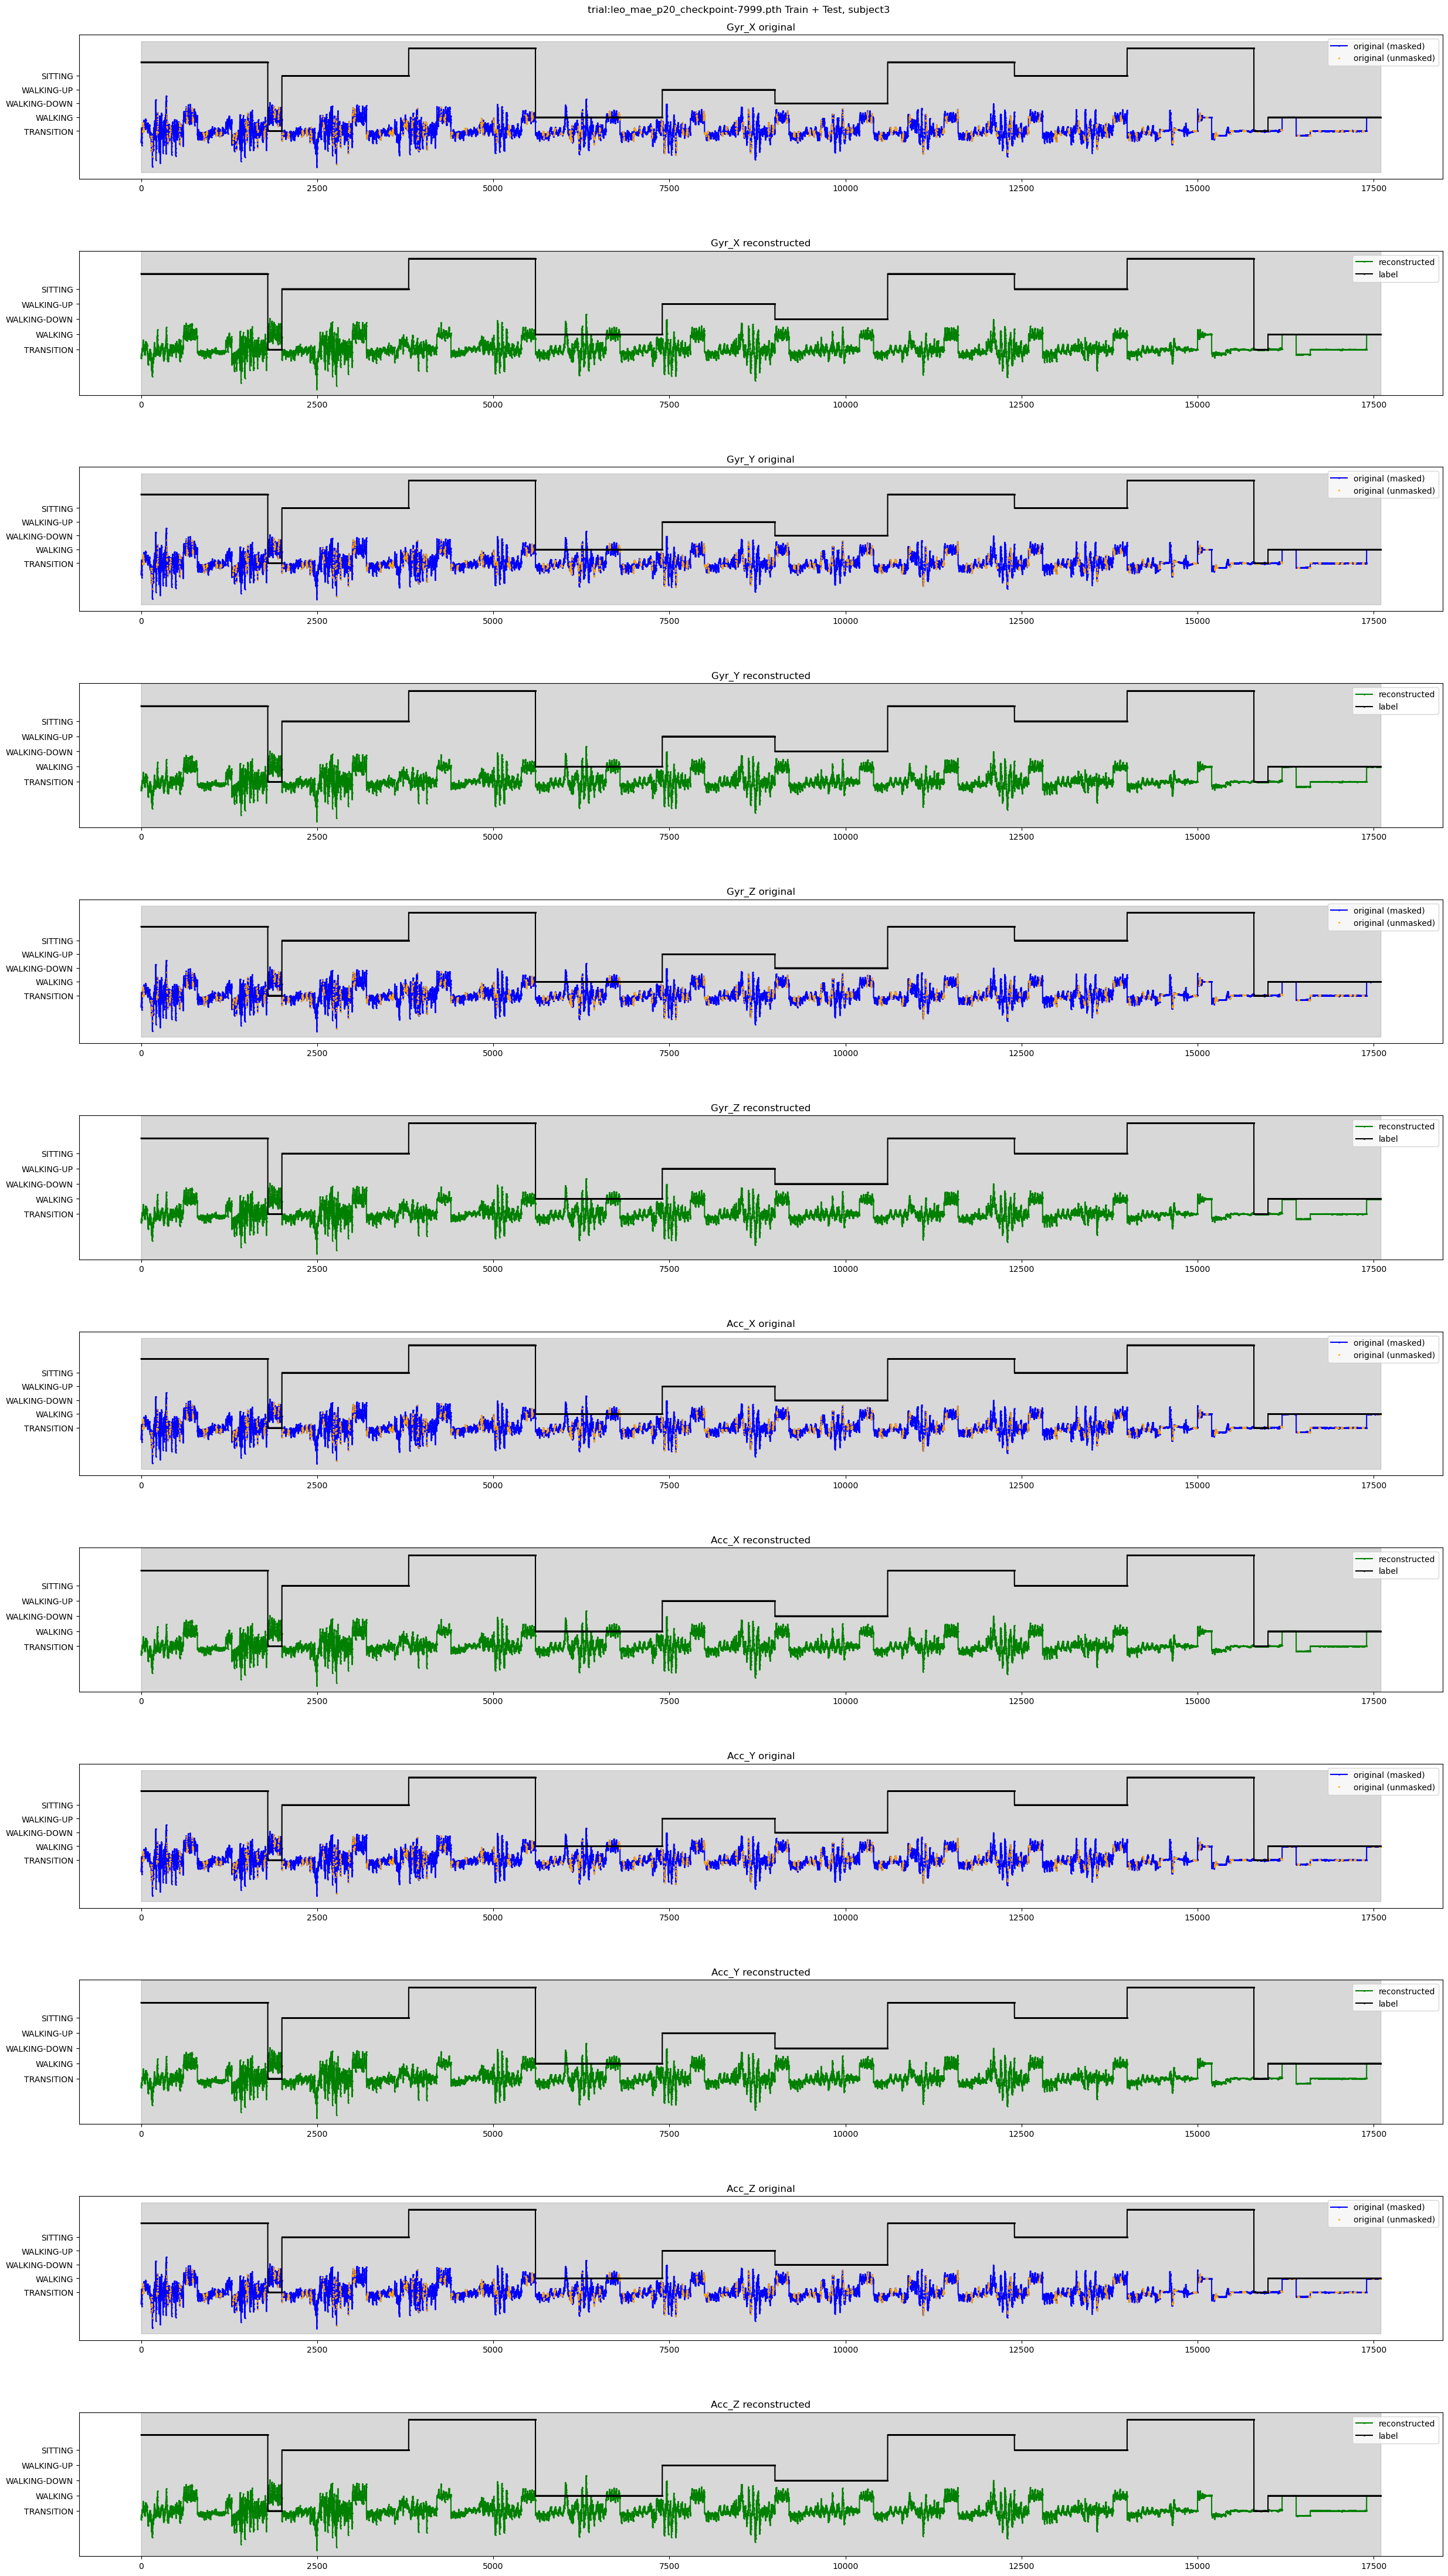

In [10]:
plot_all_reconstruction(masked_all=masked_all, x_prime_all=x_prime_all, y_all=y_all, label_y=y_all_all_mode,
                         X_test_subseq_indicator=X_test_subseq_indicator, sample_sub=3, trial=trial, ms=1, figsiz=(30, 50))

### View 2 (Comparison)

In [ ]:
#### specify the following ###
job_id = "29996"
image_length = 100
n_patches = 25
patch_length = int(image_length/n_patches)
trial= f"p{image_length}_{n_patches}"


cutoff = 17600
n_images_in_trjt = int(cutoff / image_length)

n_epochs = 1000
chkpt_dir='../persistent-data/leo/output_dir/leo_mae_p20_checkpoint-7999.pth'
normalization = False
norm_pix_loss = False
mask_ratio = 0.75
##############################





print(model.load_state_dict(checkpoint['model'], strict=False))
print(model)

X_all_subseq = torch.Tensor(torch.load(f'data/{image_length}/X_all_all.pt'))
print(X_all_subseq.shape, X_all_subseq.max(), X_all_subseq.min())

masked_all_100_25, paste_all_100_25, x_prime_all_100_25, y_all_100_25, x_squeeze_all_100_25, loss_100_25 = reconstruct_tjct(X=X_all_subseq, model=model, mask_ratio=mask_ratio, norm_pix_loss=norm_pix_loss)
print("overall loss (train+test):",loss_100_25)

In [ ]:
#### specify the following ###
job_id = "6436"
image_length = 1600
n_patches = 10
patch_length = int(image_length/n_patches)
trial= f"p{image_length}_{n_patches}"


cutoff = 17600
n_images_in_trjt = int(cutoff / image_length)

n_epochs = 1000
chkpt_dir=f'/Users/howonryu/Projects/HAR/mae/experiments/{job_id}({trial})/checkpoint-{n_epochs-1}.pth'
normalization = False
norm_pix_loss = False
mask_ratio = 0.75
##############################


def mae_vit_tiny_patch16_dec256d8b(**kwargs):
    model = MaskedAutoencoderViT(
        img_size=[1, int(image_length)], patch_size=[1, int(patch_length)], in_chans=6,
        embed_dim=192, depth=12, num_heads=3, 
        decoder_embed_dim=256, decoder_depth=8, decoder_num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

# set recommended archs
mae_vit_tiny_patch16 = mae_vit_tiny_patch16_dec256d8b

# get model from checkpoint
model_mae = mae_vit_tiny_patch16()
checkpoint = torch.load(chkpt_dir, map_location='cpu')

print(model_mae.load_state_dict(checkpoint['model'], strict=False))



X_all_subseq = torch.Tensor(torch.load(f'/Users/howonryu/Projects/HAR/mae/data/{image_length}/X_all_all.pt'))
print(X_all_subseq.shape, X_all_subseq.max(), X_all_subseq.min())

masked_all_1600_10, paste_all_1600_10, x_prime_all_1600_10, y_all_1600_10, x_squeeze_all_1600_10, loss_1600_10 = reconstruct_tjct(X=X_all_subseq, model=model_mae, mask_ratio=mask_ratio, norm_pix_loss=norm_pix_loss)
print("overall loss (train+test):",loss_100_25)

<All keys matched successfully>
torch.Size([330, 1, 1600, 6]) tensor(5.7461) tensor(-5.9743)
overall loss (train+test): 0.0064356066


In [ ]:
X_test_subseq_indicator_100 = torch.Tensor(torch.load(f"/Users/howonryu/Projects/HAR/mae/data/100/X_test_subseq_indicator.pt"))
X_test_subseq_indicator_1600 = torch.Tensor(torch.load(f"/Users/howonryu/Projects/HAR/mae/data/1600/X_test_subseq_indicator.pt"))



print(background_test_mask_1600_10.shape)

(17600,)


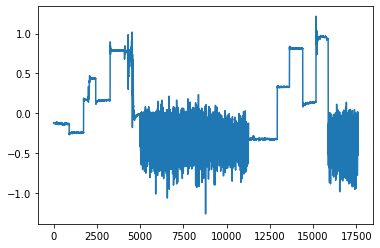

In [ ]:
plt.plot(x_squeeze_all_1600_10[:17600,4])

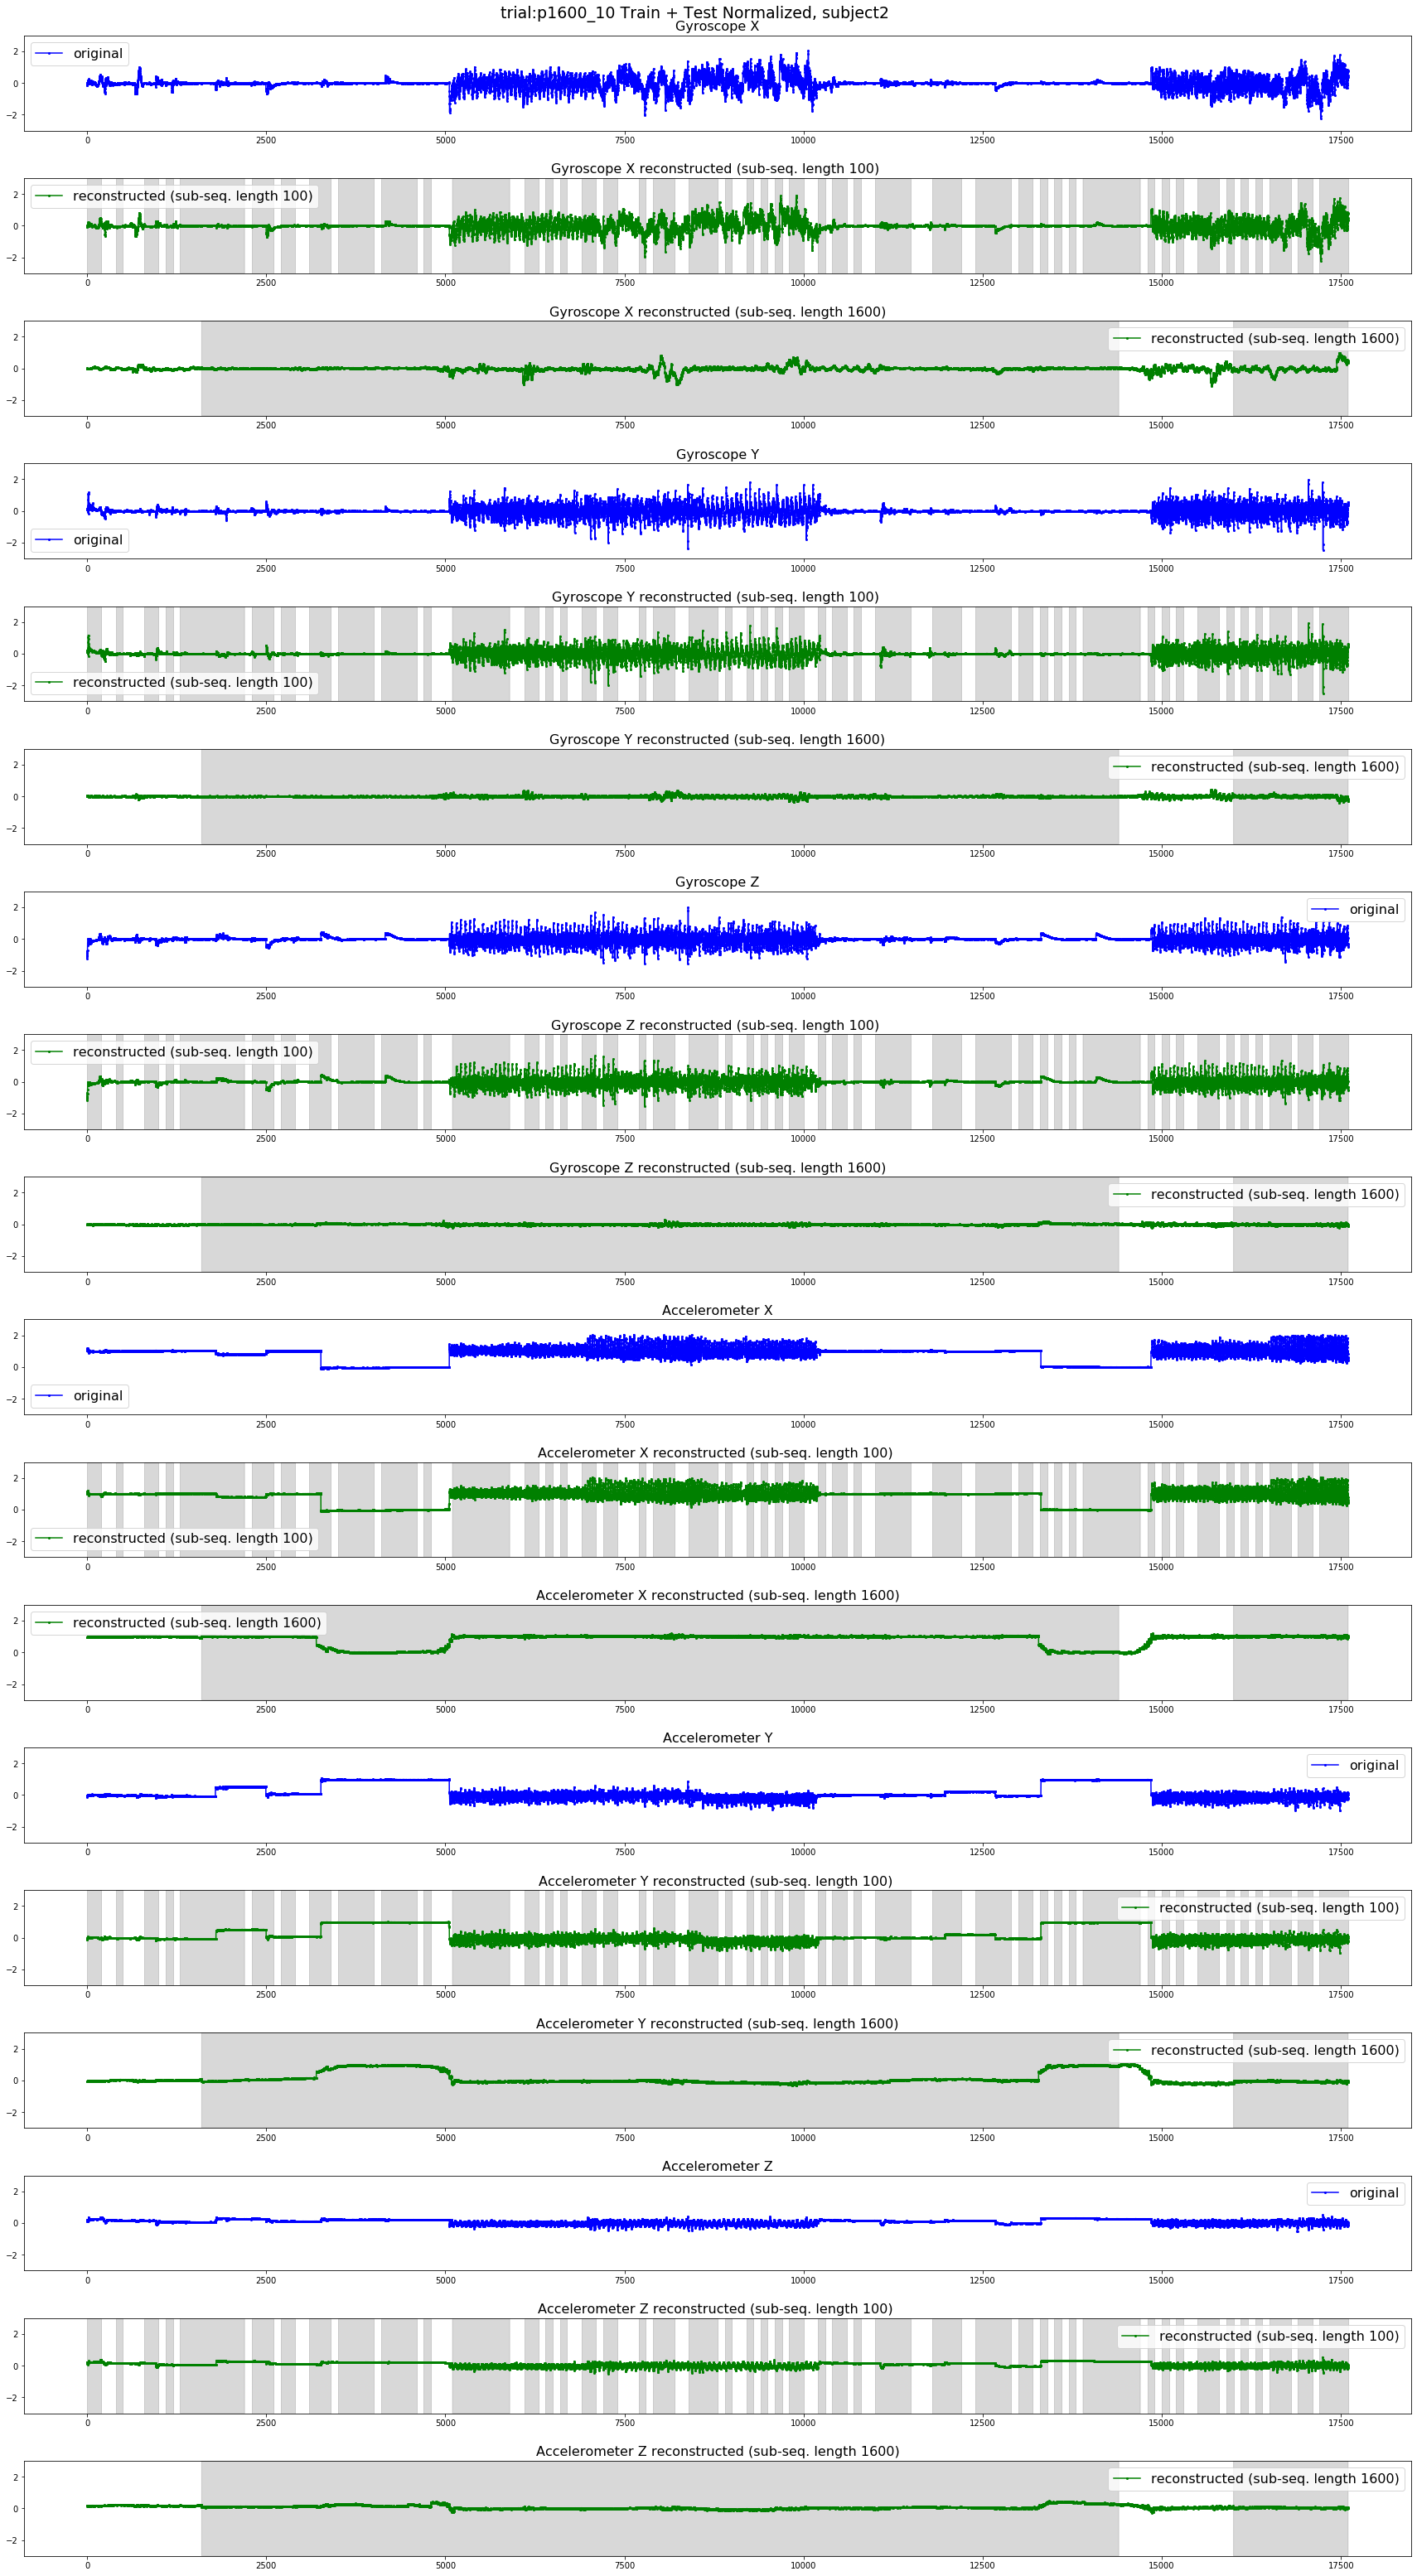

In [ ]:
sample_sub = 2

image_length = 200
n_patches = 10
patch_length_1600_10 = int(1600/10)
patch_length_100_25 = int(100/25)

n_images_in_trjt_1600_10 = int(cutoff / 1600)
n_images_in_trjt_100_25 = int(cutoff / 100)

fontsize = 16
fig, axs = plt.subplots(6*3, 1, figsize=(30, 50))
plot_labels = ['Gyroscope X', 'Gyroscope Y', 'Gyroscope Z', 'Accelerometer X', 'Accelerometer Y', 'Accelerometer Z']

title = f"trial:{trial} Train + Test Normalized, subject{sample_sub}"

X_test_subseq_indicator_100 = torch.Tensor(torch.load(f"/Users/howonryu/Projects/HAR/mae/data/100/X_test_subseq_indicator.pt"))
X_test_subseq_indicator_1600 = torch.Tensor(torch.load(f"/Users/howonryu/Projects/HAR/mae/data/1600/X_test_subseq_indicator.pt"))

for i in range(6):
    # reshape data
    #masked_plot = masked_all_100_25[sample_sub*n_images_in_trjt_100_25:(sample_sub+n_images_in_trjt_100_25)*n_images_in_trjt,0,:,i].reshape(-1)
    #paste_plot = paste_all_100_25[sample_sub*n_images_in_trjt_100_25:(sample_sub+1)*n_images_in_trjt_100_25,0,:,i].reshape(-1)
    #x_prime_plot = x_prime_all_100_25[sample_sub*n_images_in_trjt:(sample_sub+1)*n_images_in_trjt,0,:,i].reshape(-1)
    y_plot_100_25 = y_all_100_25[sample_sub*n_images_in_trjt_100_25:(sample_sub+1)*n_images_in_trjt_100_25,0,:,i].reshape(-1)
    y_plot_1600_10 = y_all_1600_10[sample_sub*n_images_in_trjt_1600_10:(sample_sub+1)*n_images_in_trjt_1600_10,0,:,i].reshape(-1)

    # test indicator
    test_indicator_100_25 = X_test_subseq_indicator_100[sample_sub*n_images_in_trjt_100_25:(sample_sub+1)*n_images_in_trjt_100_25,0,:,0].reshape(-1)
    test_indicator_1600_10 = X_test_subseq_indicator_1600[sample_sub*n_images_in_trjt_1600_10:(sample_sub+1)*n_images_in_trjt_1600_10,0,:,0].reshape(-1)
    background_test_mask_100_25 = np.where(test_indicator_100_25 == 1, 1, np.nan).astype(int)
    background_test_mask_1600_10 = np.where(test_indicator_1600_10 == 1, 1, np.nan).astype(int)

    # y limits
    ymin, ymax = -3, 3

    # plot
    ms = 2

    # original plots
    axs[i*3].plot(x_squeeze_all_1600_10[cutoff*sample_sub:cutoff*(sample_sub+1), i], marker='o', linestyle="-", color="blue", markersize=ms, label="original" )
    #axs[i*3].plot(x_prime_plot, label="original (masked)", marker='o', linestyle="-", color="blue", markersize=ms, alpha=0.3) # original but will be painted over by un_masked
    #unmasked_x = masked_plot != 0
    #indices_x = np.where(masked_plot != 0)[0]
    #axs[i*3].plot(indices_x, masked_plot[unmasked_x], label="original (unmasked)", marker='o', linestyle="", color="orange", markersize=ms, alpha=0.3)
    axs[i*3].legend(fontsize=fontsize)
    axs[i*3].set_ylim([ymin, ymax])
    axs[i*3].set_title(f"{plot_labels[i]}", fontsize=fontsize)


    # reconstruction plots - good example
    axs[i*3+1].plot(y_plot_100_25, label="reconstructed (sub-seq. length 100)", color='green', marker='o', linestyle="-", markersize=ms, alpha=1)
    axs[i*3+1].legend(fontsize=fontsize)
    axs[i*3+1].set_title(f"{plot_labels[i]} reconstructed (sub-seq. length 100) ", fontsize=fontsize)
    axs[i*3+1].set_ylim([ymin, ymax])
    axs[i*3+1].fill_between(np.arange(cutoff), ymin, ymax, where=background_test_mask_100_25, color='white', alpha=0.3)
    axs[i*3+1].fill_between(np.arange(cutoff), ymin, ymax, where=~background_test_mask_100_25, color='grey', alpha=0.3)


    # reconstruction plots - bad example
    axs[i*3+2].plot(y_plot_1600_10, label="reconstructed (sub-seq. length 1600)", color='green', marker='o', linestyle="-", markersize=ms, alpha=1)
    axs[i*3+2].legend(fontsize=fontsize)
    axs[i*3+2].set_title(f"{plot_labels[i]} reconstructed (sub-seq. length 1600)", fontsize=fontsize )
    axs[i*3+2].set_ylim([ymin, ymax])
    axs[i*3+2].fill_between(np.arange(cutoff), ymin, ymax, where=background_test_mask_1600_10, color='white', alpha=0.3)
    axs[i*3+2].fill_between(np.arange(cutoff), ymin, ymax, where=~background_test_mask_1600_10, color='grey', alpha=0.3)


plt.suptitle(title, fontsize=int(fontsize+3))
plt.subplots_adjust(hspace=0.5, top=0.97)
plt.show()


## Individual Views

torch.Size([793, 1, 200, 6])


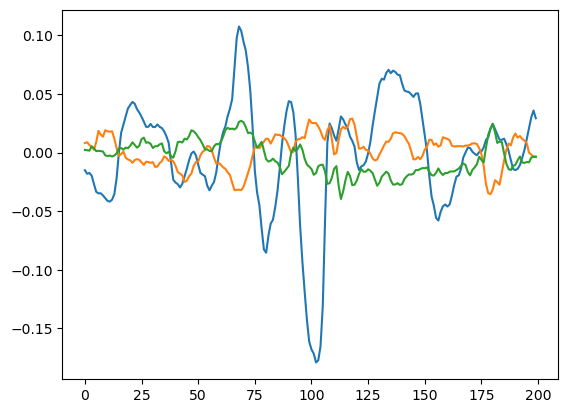

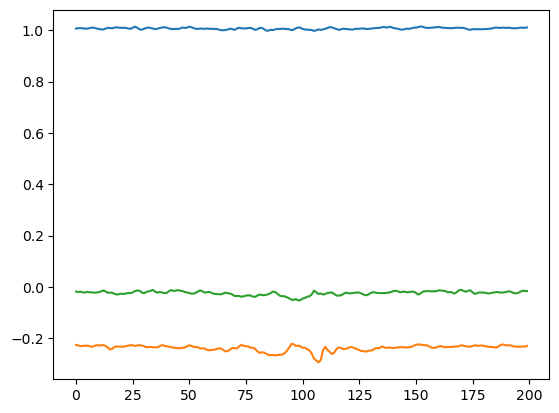

In [27]:
test_seq = torch.Tensor(torch.load(f'data/{image_length}/X_test_all.pt'))
transform_test = transforms.Compose([
    transforms.Normalize(torch.mean(test_seq, dim=(0,1,2), keepdim=True), torch.std(test_seq, dim=(0,1,2), keepdim=True))]) 
X_test_subseq_normalized = transform_test(test_seq)

### specify slice ###
slice = 10


# 6
### specify slice ###

if normalization:
    test1 = X_test_subseq_normalized[slice,:,:,:]
else:
    test1 = test_seq[slice,:,:,:]



print(X_test_subseq_normalized.shape)
plt.plot(test1[0, :, 0]) # xaxis
plt.plot(test1[0, :, 1]) # yaxis
plt.plot(test1[0, :, 2]) # zaxis
plt.show()
plt.plot(test1[0, :, 3]) # xaxis
plt.plot(test1[0, :, 4]) # yaxis
plt.plot(test1[0, :, 5]) # zaxis
plt.show()

torch.Size([1, 6, 200])
x_prime shape: torch.Size([6, 200])
masked shape: torch.Size([6, 200])
y shape: torch.Size([6, 200])


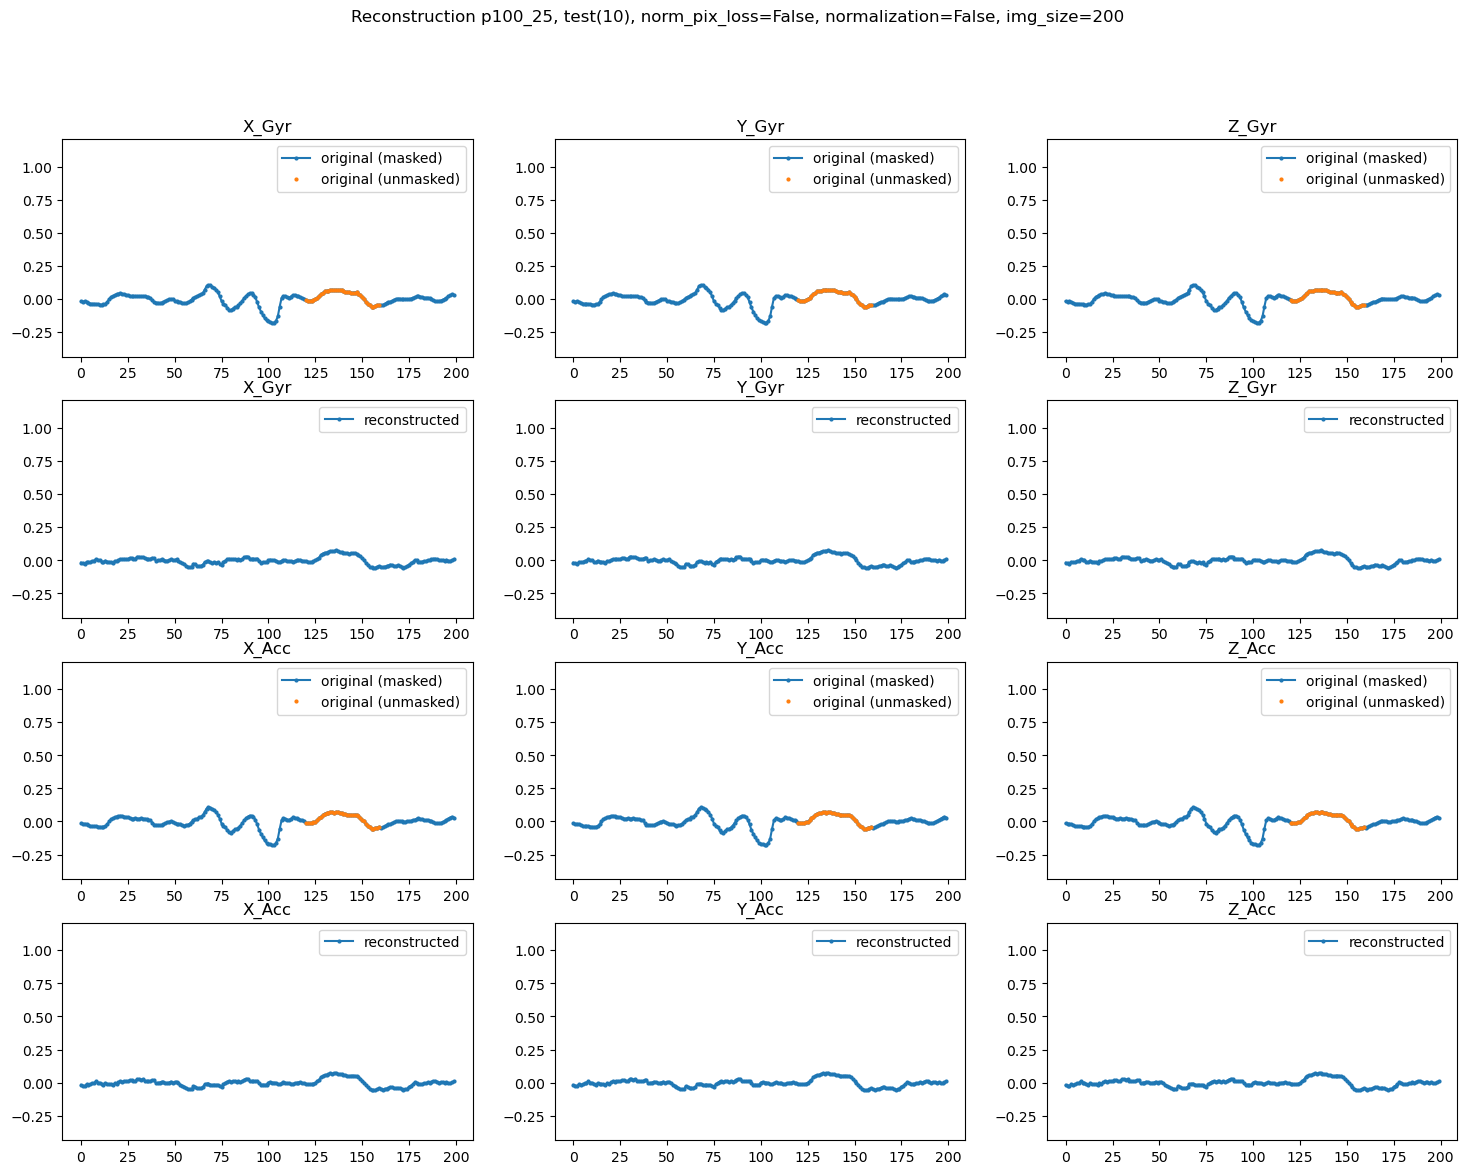

In [44]:
title = f"{trial}, test({slice}), norm_pix_loss={norm_pix_loss}, normalization={normalization}, img_size={model.ts_len}"
x = test1
model_mae = model

if alt:
    x = x.permute(2, 1, 0)

x = x.permute(0, 2, 1)

print(x.shape)
masked, paste, x_prime, y, loss = mae_pass(x=x, model=model, mask_ratio=mask_ratio, norm_pix_loss=norm_pix_loss, alt=alt)

if alt:
    masked = masked.permute(0, 3, 2, 1)
    paste = paste.permute(0, 3, 2, 1)
    x_prime = x_prime.permute(0, 3, 2, 1)
    y = y.permute(0, 3, 2, 1)
    
# Print tensor shapes for debugging
print(f"x_prime shape: {x_prime.shape}")
print(f"masked shape: {masked.shape}")
print(f"y shape: {y.shape}")

# Calculate y limits
y_squeeze = y.squeeze(dim=0).squeeze(dim=0)
ymin_lims = torch.min(y_squeeze, axis=0)
ymax_lims = torch.max(y_squeeze, axis=0)
marg = 0.2

ms = 2
linestyle = '-'
linestyle_unmasked = ''
modalities = ["Gyr", "Acc"]
axes = ['X', "Y", "Z"]
fig, axs = plt.subplots(len(modalities) * 2, len(axes), figsize=(18, 13))

if alt:
    for i, modal in enumerate(modalities):
        for j, ax in enumerate(axes):
            # Adjusted indexing for 2D or 3D tensors
            if x_prime.dim() == 3:  # [batch_size, length, features]
                axs[2*i, j].plot(x_prime[0, :, 2*i + j], label="original (masked)", marker='o', linestyle=linestyle, markersize=ms)
                unmasked_x = masked[0, :, 2*i + j] != 0
                indices_x = np.where(masked[0, :, 2*i + j] != 0)[0]
                axs[2*i, j].plot(indices_x, masked[0, unmasked_x, 2*i + j], label="original (unmasked)", marker='o', linestyle=linestyle_unmasked, markersize=ms)
                axs[2*i+1, j].plot(y[0, :, 2*i + j], label="reconstructed", marker='o', linestyle=linestyle, markersize=ms)

            elif x_prime.dim() == 2:  # [batch_size, length]
                axs[2*i, j].plot(x_prime[0, :], label="original (masked)", marker='o', linestyle=linestyle, markersize=ms)
                unmasked_x = masked[0, :] != 0
                indices_x = np.where(masked[0, :] != 0)[0]
                axs[2*i, j].plot(indices_x, masked[0, unmasked_x], label="original (unmasked)", marker='o', linestyle=linestyle_unmasked, markersize=ms)
                axs[2*i+1, j].plot(y[0, :], label="reconstructed", marker='o', linestyle=linestyle, markersize=ms)
            
            axs[2*i, j].legend()
            axs[2*i, j].set_title(f"{ax}_{modal}")
            axs[2*i, j].set_ylim([ymin_lims.values[2*i+j] - marg, ymax_lims.values[2*i+j] + marg])

            axs[2*i+1, j].legend()
            axs[2*i+1, j].set_title(f"{ax}_{modal}")
            axs[2*i+1, j].set_ylim([ymin_lims.values[2*i+j] - marg, ymax_lims.values[2*i+j] + marg])

    plt.suptitle(f"Reconstruction {title}")

else:
    for i, modal in enumerate(modalities):
        for j, ax in enumerate(axes):
            # Adjusted indexing for 2D or 3D tensors
            if x_prime.dim() == 3:  # [batch_size, length, features]
                axs[2*i, j].plot(x_prime[0, :, i], label="original (masked)", marker='o', linestyle=linestyle, markersize=ms)
                unmasked_x = masked[0, :, i] != 0
                indices_x = np.where(masked[0, :, i] != 0)[0]
                axs[2*i, j].plot(indices_x, masked[0, unmasked_x, i], label="original (unmasked)", marker='o', linestyle=linestyle_unmasked, markersize=ms)
                axs[2*i+1, j].plot(y[0, :, i], label="reconstructed", marker='o', linestyle=linestyle, markersize=ms)

            elif x_prime.dim() == 2:  # [batch_size, length]
                axs[2*i, j].plot(x_prime[0, :], label="original (masked)", marker='o', linestyle=linestyle, markersize=ms)
                unmasked_x = masked[0, :] != 0
                indices_x = np.where(masked[0, :] != 0)[0]
                axs[2*i, j].plot(indices_x, masked[0, unmasked_x], label="original (unmasked)", marker='o', linestyle=linestyle_unmasked, markersize=ms)
                axs[2*i+1, j].plot(y[0, :], label="reconstructed", marker='o', linestyle=linestyle, markersize=ms)
            
            axs[2*i, j].legend()
            axs[2*i, j].set_title(f"{ax}_{modal}")
            axs[2*i, j].set_ylim([ymin_lims.values[i] - marg, ymax_lims.values[i] + marg])

            axs[2*i+1, j].legend()
            axs[2*i+1, j].set_title(f"{ax}_{modal}")
            axs[2*i+1, j].set_ylim([ymin_lims.values[i] - marg, ymax_lims.values[i] + marg])

    plt.suptitle(f"Reconstruction {title}")

plt.show()


In [ ]:
!tensorboard --logdir tensorboard_log

2024-05-02 20:51:07.961199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.


# MAE Classification

## Model Load

In [ ]:
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block
import timm.models.vision_transformer


class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool=False, num_channels=6, **kwargs): # 
        super(VisionTransformer, self).__init__(**kwargs)


        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x) # changed - added

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]

        return outcome
    

def mae_classification_pass(X, y, model):
    # define data set and sampler
    dataset = torch.utils.data.TensorDataset(torch.Tensor(X),  y)
    sampler = torch.utils.data.SequentialSampler(dataset)
    # define data loader
    data_loader = torch.utils.data.DataLoader(dataset, sampler=sampler, batch_size=50, num_workers=1, drop_last=False)
    
    # initialize for loop
    preds = list()
    targets = list()
    for batch in iter(data_loader):
        images = batch[0]
        target = batch[-1]
     
        output = model(images)
        pred = np.argmax(output.detach().numpy(), axis=1)

        #images_for_plot = torch.einsum('nchw -> nhwc', images)
        #plt.plot(images_for_plot[0,0,:,3], label="x")
        #plt.plot(np.repeat(target, 200), label="target")
        #plt.plot(np.repeat(pred, 200), label="pred")
        #plt.show()

        preds.append(pred)
        targets.append(target)

    #print("image shape:", images.shape, "target shape:", target.shape, "output shape:", output.shape)
    #print("target:", target, "pred:", pred)

    #acc1, acc3 = accuracy(output, target, topk=(1, 3)) 
    #print("acc1, acc3:", acc1, acc3)
    preds_list = list(chain(*preds))
    targets_list = list(chain(*targets))
    accordance = np.array(preds_list) == np.array(targets_list)
    accuracy = np.sum(accordance)/len(preds_list)

    return preds_list, targets_list, accuracy


In [ ]:
# checkpoint
job_id = "54178"
trial_classification= "16-22_nnc"
n_epochs = 100
chkpt_dir=f'/Users/howonryu/Projects/HAR/mae/experiments/{job_id}(trial{trial_classification})/checkpoint-{n_epochs-1}.pth'
normalization_classification = False

def vit_tiny_patch16(**kwargs):
    model = VisionTransformer(
        img_size=[1, 200], patch_size=[1,5], num_classes=7, in_chans=6, embed_dim=192, depth=12, num_heads=3,
        mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
vit_tiny_patch16 = vit_tiny_patch16

# get model from checkpoint
model_mae_classification = vit_tiny_patch16()
checkpoint = torch.load(chkpt_dir, map_location='cpu')

print(model_mae_classification.load_state_dict(checkpoint['model'], strict=False))

NameError: name 'VisionTransformer' is not defined

## Load Dataset

In [ ]:
# Load train and test data set
X_train_subseq = torch.Tensor(torch.load('/Users/howonryu/Projects/HAR/mae/data/200/X_train_all.pt')).permute(0, 3, 1, 2)
X_test_subseq = torch.Tensor(torch.load('/Users/howonryu/Projects/HAR/mae/data/200/X_test_all.pt')).permute(0, 3, 1, 2)

y_train_subseq = torch.Tensor(torch.load('/Users/howonryu/Projects/HAR/mae/data/200/y_train_all_mode.pt')).type(torch.LongTensor)
y_test_subseq = torch.Tensor(torch.load('/Users/howonryu/Projects/HAR/mae/data/200/y_test_all_mode.pt')).type(torch.LongTensor)


# with X normalization
transform_train = transforms.Compose([
    transforms.Normalize(torch.mean(X_train_subseq, dim=(0,2,3)), torch.std(X_train_subseq, dim=(0,2,3)))])
transform_test = transforms.Compose([
    transforms.Normalize(torch.mean(X_test_subseq, dim=(0,2,3)), torch.std(X_test_subseq, dim=(0,2,3)))])
    
X_train_subseq_normalized = transform_train(X_train_subseq)
X_val_subseq_normalized = transform_test(X_test_subseq)


# concatenate train + test
X_all_subseq_normalized = torch.Tensor(np.concatenate([X_train_subseq_normalized, X_val_subseq_normalized]))
y_all_subseq = torch.Tensor(np.concatenate([np.array(y_train_subseq), np.array(y_test_subseq)]))

X_all_subseq = torch.Tensor(np.concatenate([X_train_subseq, X_test_subseq]))


## Activity Prediction

In [1]:
if normalization_classification:
    X_all_subseq_arg_classification = X_all_subseq_normalized
    X_val_subseq_arg_classification = X_val_subseq_normalized
else:
    X_all_subseq_arg_classification = X_all_subseq
    X_val_subseq_arg_classification = X_test_subseq

pred_all, target_all, accuracy_all = mae_classification_pass(X=X_all_subseq_arg_classification, y=y_all_subseq, model=model_mae_classification)
pred_test, target_test, accuracy_test = mae_classification_pass(X=X_val_subseq_arg_classification, y=y_test_subseq, model=model_mae_classification)

NameError: name 'normalization_classification' is not defined

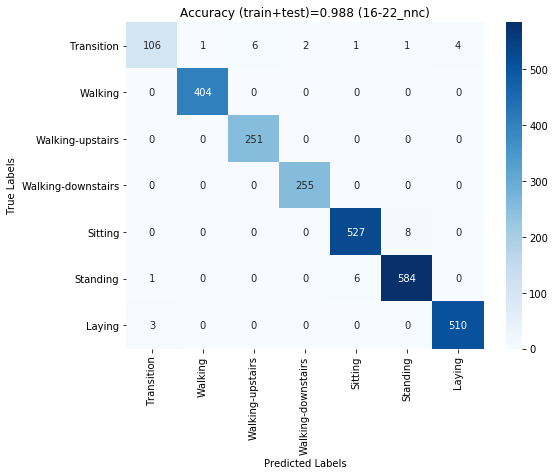

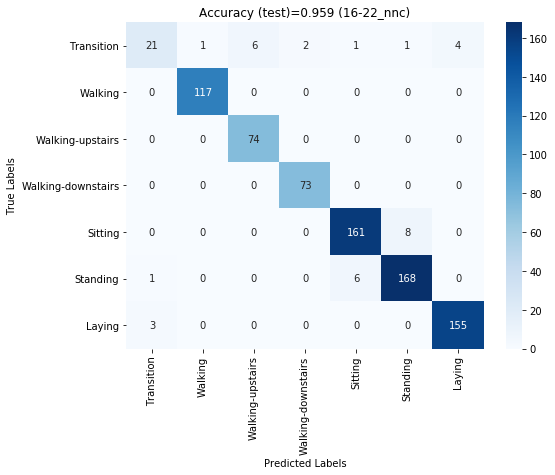

In [ ]:
cm_all = confusion_matrix(target_all, pred_all)

#labels = ['Transition', 'Walking', 'Sitting', 'Standing', 'Laying']
labels = ['Transition', 'Walking', 'Walking-upstairs', 'Walking-downstairs', 'Sitting', 'Standing', 'Laying']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, cmap='Blues', fmt='d', xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Accuracy (train+test)={round(accuracy_all,3)} ({trial_classification})')
plt.show()

cm_test = confusion_matrix(target_test, pred_test)


plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Accuracy (test)={round(accuracy_test,3)} ({trial_classification})')
plt.show()

# Paper Image Ablation Plot

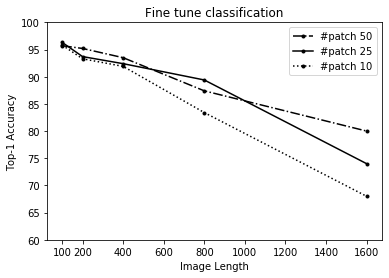

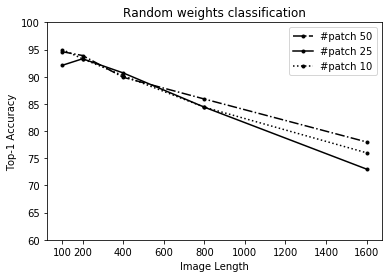

In [ ]:
x_axis = [100, 200, 400, 800, 1600]
finetune_10 = [95.8, 93.3, 91.9, 83.4, 68]
finetune_25 =[96.3, 93.7, 92.4, 89.4, 74]
finetune_50 = [95.7, 95.2, 93.5, 87.4, 80]

random_10 = [95, 93.3, 90.2, 84.4, 76]
random_25 = [92.1, 93.3, 90.7, 84.4, 73]
random_50 = [94.6, 93.9, 89.9, 85.9, 78]


plt.plot(x_axis, finetune_50, marker='.', linestyle="-.", color="black", label="#patch 50")
plt.plot(x_axis, finetune_25, marker='.', linestyle="-", color="black", label="#patch 25")
plt.plot(x_axis, finetune_10, marker='.', linestyle=":", color="black", label="#patch 10")
plt.ylim(60,100)
plt.xticks([100, 200, 400, 600, 800, 1000, 1200, 1400, 1600])
plt.xlabel("Image Length")
plt.ylabel("Top-1 Accuracy")
plt.title("Fine tune classification")
plt.legend()
plt.show()



plt.plot(x_axis, random_50, marker='.', linestyle="-.", color="black", label="#patch 50")
plt.plot(x_axis, random_25, marker='.', linestyle="-", color="black", label="#patch 25")
plt.plot(x_axis, random_10, marker='.', linestyle=":", color="black", label="#patch 10")
plt.ylim(60,100)
plt.xticks([100, 200, 400, 600, 800, 1000, 1200, 1400, 1600])
plt.xlabel("Image Length")
plt.ylabel("Top-1 Accuracy")
plt.title("Random weights classification")
plt.legend()
plt.show()





In [2]:
file_path = '/niddk-data-central/iWatch/pre_processed_long_seg/W/10s_train.h5'
import h5py
with h5py.File(file_path, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['subject_id', 'timestamp', 'x', 'y']>
